In [1]:
%cd ..

/scratch/gpfs/zzada/narrative-gradients


In [2]:
import h5py
import glob
import torch
import numpy as np
import pandas as pd
import IPython

from util import plot
from util.atlas import Atlas
import matplotlib.pyplot as plt

# visualization

In [8]:
from scipy.io import wavfile
from scipy.stats import zscore

In [ ]:
sf, black_audio = wavfile.read("data/stimuli/audio/black_audio.wav")
sf, forgot_audio = wavfile.read("data/stimuli/audio/forgot_audio.wav")

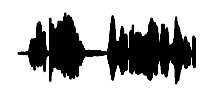

In [18]:
plt.figure(figsize=(2.5, 1))
plt.plot(zscore(black_audio[:int(sf*3.976)]), c='k')
plt.axis('off')
# plt.savefig("figures/fig1-black-waveform.svg")
plt.show()

In [20]:
print(len(black_audio) / sf / 60)
print(len(forgot_audio) / sf / 60)

13.333333333333334
13.95


/tmp/ipykernel_2980948/4242642678.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, forgot_audio = wavfile.read("data/stimuli/audio/forgot_audio.wav")


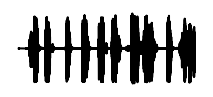

In [ ]:

plt.figure(figsize=(2.5, 1))
plt.plot(zscore(forgot_audio[:sf*15]), c='k')
plt.axis('off')
plt.savefig("figures/fig1-forgot-waveform.svg")
plt.show()

# old

In [ ]:
from whisper import load_audio
from himalaya.scoring import correlation_score
from transformers import WhisperModel, WhisperFeatureExtractor, WhisperTokenizer

In [4]:
audio = load_audio('data/stimuli/audio/black_audio.wav')
audio.shape

(12800000,)

In [5]:
sfreq = 16000
tr_ms = 1.5 * 1000
audio.size / sfreq, tr_ms

(800.0, 1500.0)

In [6]:
import json

with open('data/stimuli/whisperx/black_audio.json') as f:
    df = pd.DataFrame(json.load(f)['word_segments'])

In [7]:
df

,word,start,end,score
0,So,0.351,1.172,0.912
1,I,1.192,1.212,0.001
2,was,2.053,2.294,0.807
3,a,2.374,2.434,0.672
4,junior,2.554,3.135,0.769
...,...,...,...,...
1525,what,790.827,790.987,0.922
1526,I,791.087,791.167,0.999
1527,do.,791.207,791.407,0.947
1528,Thank,792.408,792.568,0.301


In [8]:
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-medium.en")
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-large", task='transcribe', language='english')
model = WhisperModel.from_pretrained("openai/whisper-medium.en")

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
model = model.eval()
model

WhisperModel(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 384)
    (layers): ModuleList(
      (0-3): 4 x WhisperEncoderLayer(
        (self_attn): WhisperSdpaAttention(
          (k_proj): Linear(in_features=384, out_features=384, bias=False)
          (v_proj): Linear(in_features=384, out_features=384, bias=True)
          (q_proj): Linear(in_features=384, out_features=384, bias=True)
          (out_proj): Linear(in_features=384, out_features=384, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (final_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    

In [5]:
model.decoder.config

WhisperConfig {
  "_name_or_path": "openai/whisper-medium.en",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "apply_spec_augment": false,
  "architectures": [
    "WhisperForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "begin_suppress_tokens": [
    220,
    50256
  ],
  "bos_token_id": 50257,
  "classifier_proj_size": 256,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 24,
  "decoder_start_token_id": 50257,
  "dropout": 0.0,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 24,
  "eos_token_id": 50256,
  "forced_decoder_ids": [
    [
      1,
      50362
    ]
  ],
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "mask_feature_length": 10,
  "mask_feature_min_masks": 0,
  "mask_feature_prob": 0.0,
  "mask_time_length": 10,
  "mask_time_min_masks": 2,
  "mask_time_prob": 0.05,
  "max_length": 448,
  "max_source_posit

In [9]:
examples = []
for i, row in df.iterrows():
    end_s = row.end
    start_s = max(0, end_s - 30)
    sub_df = df[(df.start > start_s) & (df.start < end_s)]

    sub_audio = audio[int(start_s * sfreq) : int(end_s * sfreq)]
    print(i, start_s, end_s, sub_audio.shape)

    input_features = feature_extractor(sub_audio, sampling_rate=sfreq, return_attention_mask=True, return_tensors="pt")
    text = ' ' + ' '.join(sub_df.word.tolist())
    tokens = tokenizer.encode(text, return_tensors='pt')

    examples.append(dict(
        word=row.word,
        duration=row.end-row.start,
        audio=sub_audio,
        audio_dur=sub_audio.size / sfreq,
        input_features=input_features.input_features,
        audio_samples=input_features.attention_mask[0].nonzero()[-1].item() + 1,
        decoder_input_ids=tokens,
        n_tokens=len(tokenizer.tokenize(' ' + row.word))
    ))
    if i > 10:
        break

0 0 1.172 (18752,)
1 0 1.212 (19392,)
2 0 2.294 (36704,)
3 0 2.434 (38944,)
4 0 3.135 (50160,)
5 0 3.375 (54000,)
6 0 3.976 (63616,)
7 0 4.997 (79952,)
8 0 5.117 (81872,)
9 0 5.338 (85408,)
10 0 5.558 (88928,)
11 0 6.159 (98544,)


In [10]:
example = examples[-1]
example

{'word': 'first',
 'duration': 0.4609999999999994,
 'audio': array([ 0.        ,  0.        ,  0.        , ..., -0.00082397,
         0.0062561 , -0.00592041], dtype=float32),
 'audio_dur': 6.159,
 'input_features': tensor([[[-0.7218, -0.7218, -0.7218,  ..., -0.7218, -0.7218, -0.7218],
          [-0.7218, -0.7218, -0.7218,  ..., -0.7218, -0.7218, -0.7218],
          [-0.7218, -0.7218, -0.7218,  ..., -0.7218, -0.7218, -0.7218],
          ...,
          [-0.7218, -0.7218, -0.7218,  ..., -0.7218, -0.7218, -0.7218],
          [-0.7218, -0.7218, -0.7218,  ..., -0.7218, -0.7218, -0.7218],
          [-0.7218, -0.7218, -0.7218,  ..., -0.7218, -0.7218, -0.7218]]]),
 'audio_samples': 616,
 'decoder_input_ids': tensor([[50258, 50259, 50359, 50363,   407,   286,   390,   257, 16195,   294,
           3859,   562,   286,   658,   452,   700, 50257]]),
 'n_tokens': 1}

In [11]:
with torch.no_grad():
    outputs = model(input_features=example['input_features'],
                    decoder_input_ids=example['decoder_input_ids'],
                    output_hidden_states=True)
outputs.keys()

odict_keys(['last_hidden_state', 'past_key_values', 'decoder_hidden_states', 'encoder_last_hidden_state', 'encoder_hidden_states'])

In [15]:
IPython.display.Audio(example['audio'], rate=sfreq)

In [16]:
example['duration'], example['audio_dur'], example['audio_samples']

(0.12000000000000455, 30.0, 3000)

In [ ]:
n_frames = int(np.ceil(example['duration'] / 0.2))  # duration of word by 20 ms
end_frame = int(np.ceil(example['audio_samples'] / 2))  # / 2 to account for conv from 3000 -> 1500 frames
temporal_slice = slice(end_frame - n_frames, end_frame + 1)
temporal_slice, n_frames, end_frame

(slice(1499, 1501, None), 1, 1500)

(2990.0, 3010.0)

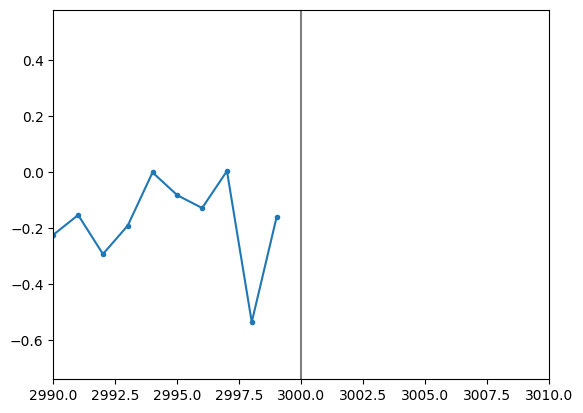

In [18]:
plt.axvline(end_frame * 2, alpha=0.5, c='k')
plt.plot(example['input_features'][0, 0], marker='.')
plt.xlim(end_frame * 2 - 10, end_frame * 2 + 10)

In [19]:
conv_state = outputs['encoder_hidden_states'][0]
conv_state.shape

torch.Size([1, 1500, 384])

(1450.0, 1510.0)

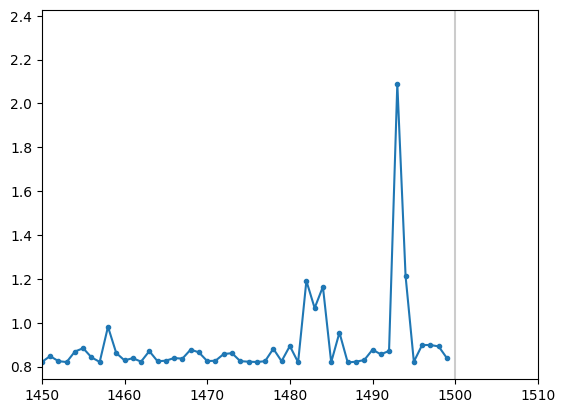

In [20]:
plt.plot(conv_state[0, :, -1], marker='.')
plt.axvline(end_frame, alpha=0.2, c='k')
plt.xlim(end_frame - 50, end_frame + 10)

In [21]:
encoder_state = outputs['encoder_hidden_states'][-1]
encoder_state.shape

torch.Size([1, 1500, 384])

In [22]:
decoder_layer = 3
decoder_state = outputs['decoder_hidden_states'][decoder_layer]
decoder_state.shape

torch.Size([1, 83, 384])

In [28]:
states = torch.stack(outputs['decoder_hidden_states'])
states.shape

torch.Size([5, 1, 83, 384])

In [14]:
tokenizer.convert_ids_to_tokens(example['decoder_input_ids'][0])

['<|startoftranscript|>',
 '<|en|>',
 '<|transcribe|>',
 '<|notimestamps|>',
 'ĠSo',
 'ĠI',
 'Ġwas',
 'Ġa',
 'Ġjunior',
 'Ġin',
 'Ġcollege',
 'Ġwhen',
 'ĠI',
 'Ġgot',
 'Ġmy',
 'Ġfirst',
 '<|endoftext|>']

In [12]:
decoder_emb_slice = slice(- (example['n_tokens'] + 1), -1)
decoder_emb_slice

slice(-2, -1, None)

In [13]:
tokenizer.decode(example['decoder_input_ids'][0, decoder_emb_slice])

' first'

In [ ]:
conv_state = outputs["encoder_hidden_states"][0]
encoder_state = outputs["encoder_hidden_states"][-1]
decoder_states = outputs["decoder_hidden_states"]

conv_state = conv_state[0, temporal_slice].mean(0)
encoder_state = encoder_state[0, temporal_slice].mean(0)
decoder_states = torch.stack(decoder_states)
decoder_states = decoder_states[:, 0, decoder_emb_slice].mean(1)

In [36]:
conv_state.shape, encoder_state.shape, decoder_states.shape

(torch.Size([384]), torch.Size([384]), torch.Size([5, 384]))

# Old

In [ ]:
narrative = 'forgot'
narrative = 'black'

modelname = 'acoustic'
modelname = 'syntactic'
modelname = 'articulatory'
modelname = 'gemma-2b'

narratives = ['black', 'forgot']
models = ['acoustic', 'articulatory', 'syntactic', 'gemma-2b', 'gemma2-9b_22-layer']
# layer = 16

In [ ]:
foldername = 'encoding'
modelname = models[-1]
print(modelname)

files = glob.glob(f'results/{foldername}/sub-*/{modelname}/*h5')
len(files)

In [ ]:
for filename in files:
    with h5py.File(filename, 'r') as f:
        preds = f['black_preds'][1, :, :].sum(0)
        zeros = np.nonzero(preds == 0)[0]
        if len(zeros):
            print(filename, zeros)

In [ ]:
with h5py.File(f'results/encoding/sub-267/{modelname}/sub-267.h5') as f:
    print(f.keys())
    black_scores = f['black_scores'][...]
    black_actual = f['black_actual'][...]
    forgot_actual = f['forgot_actual'][...]
    black_preds = f['black_preds'][...]

In [ ]:
plt.plot(black_actual[:, 69])
plt.plot(forgot_actual[:, 69])